## 生成高阶曲面

对于奇怪的，但是具有参数表达式的曲面，生成高阶网格

In [1]:
from ngsolve import *

In [2]:
# from netgen.csg import Pnt,SplineCurve2d,CSGeometry,Revolution,Sphere
import numpy as np
import netgen.meshing as ngm
from netgen.csg import *
from netgen.meshing import MeshingStep
from ngsolve.comp import IntegrationRuleSpaceSurface

In [3]:
from es_utils import pos_transformer, SurfacehInterp

In [4]:
from geometry import *

In [5]:
from esfem import WillMoreMDR

In [6]:
from ngsolve.webgui import Draw

In [7]:
from ngsolve import Mesh

In [8]:
from netgen.occ import SplineApproximation, Pnt, Axis, Face, Wire, Segment, Revolve, OCCGeometry, Z, X, Y
#%% Construction of Initial Curved Mesh
dim = 3
order = 2
msize = 0.1
dt = Parameter(0)

In [9]:
def GetRotFace(CurveFunc,msize,T_min=-np.pi/2,T_max=np.pi/2,axis=Z,is_close=False,n=100):
    '''
        Generate Rotational Mesh by revolving a 2d curve (CurveFunc) around an axis (axis)
        CurveFunc: function of phi, return (x(phi), 0, z(phi)) for example
        axis: axis of rotation, default z-axis: curve on x-z plane around z-axis
        is_close: whether the curve is closed (first point = last point)
        n: number of points on the curve
        T_min, T_max: parameter range of the curve
        msize: mesh size
        return: mesh 
    '''
    pnts = [CurveFunc(phi) for phi in np.linspace(T_min,T_max,n)]
    spline = SplineApproximation(pnts, tol=1e-4)
    f = Face(Wire([spline]))
    return f

In [10]:
def BaseTorus(phi): 
    a = 0.65
    z = a*np.sin(phi)
    res = Pnt(1+a*np.cos(phi), 0, z)
    return res

### Step 1: 生成低阶网格

In [11]:
f = GetRotFace(BaseTorus,0.08,T_min=np.pi,
                  T_max=3*np.pi,axis=Z,is_close=True)

In [12]:
# 在occ中设置某个点的mesh size
f.edges[0].vertices[0].maxh = 0.05

In [13]:
torus = f.Revolve(Axis((0,0,0), Z), 360)
mesh = Mesh(OCCGeometry(torus).GenerateMesh(maxh=msize,
            perfstepsend=ngm.MeshingStep.MESHSURFACE,grading=0.5))

* 可以直接加载一阶网格

In [14]:
mesh = Mesh("../../../data/order_1_mesh.vol")
fes = H1(mesh,order=1)
fesV = VectorH1(mesh,order=1)

Disp = GridFunction(fesV)
data = np.load("../../../data/order_1_deformation.npz")
Disp.vec.data = BaseVector(data["deform"].flatten("F"))
mesh.SetDeformation(Disp)

### Step 2: 在低阶网格的高次有限元空间上进行插值

In [15]:
fesir = IntegrationRuleSpaceSurface(mesh, order=2, definedon=mesh.Boundaries('.*'))
irs = fesir.GetIntegrationRules()

In [16]:
mesh.UnsetDeformation()
interp_obj = SurfacehInterp(mesh,order)
init_coords_3d = interp_obj.get_coords_quad() # 通过Interpolation

In [17]:
mesh.SetDeformation(Disp)
interp_obj = SurfacehInterp(mesh,order)
coords_3d = interp_obj.get_coords_quad() # 通过Interpolation
Disp0 = GridFunction(fesV)
get_gfu = lambda x: interp_obj.return_l2(x,deform=Disp) # 固定deform，防止曲面变化

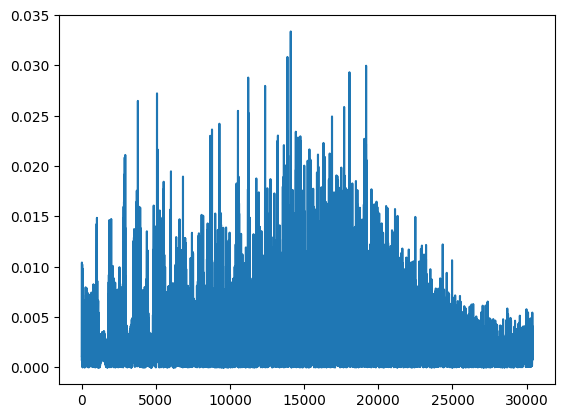

In [18]:
from geometry.param_curve import phi, psi
import sympy as sp
X_perturbed = sp.Matrix([
    (1 + 0.65*sp.cos(phi)) * sp.cos(psi),
    (1 + 0.65*sp.cos(phi)) * sp.sin(psi),
    0.65*sp.sin(phi) + 0.3*sp.sin(5*psi)
])
obj = ParamSurface(X_perturbed,num_points=400000)

phi_values, psi_values, points, tol_info = obj.proj_param(coords_3d,tol=1e-8,max_iter=10)

import matplotlib.pyplot as plt
plt.plot(np.linalg.norm(points - coords_3d, axis = 1))

In [19]:
fesV2 = VectorH1(mesh,order=order)
init_deformation = GridFunction(fesV2)

In [20]:
# 将Interpolation的位置点投影到精确曲面上
def_coords = points - init_coords_3d
deformx, deformy, deformz = map(get_gfu,[def_coords[:,0],def_coords[:,1],def_coords[:,2]])
deform_xyz = np.concatenate([deformx, deformy, deformz])
init_deformation.vec.data = BaseVector(deform_xyz)

In [21]:
mesh.SetDeformation(init_deformation)

In [22]:
Draw(Norm(Trace(specialcf.Weingarten(3))),mesh,"vv")
# Draw(x,mesh,"vv")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [23]:
mesh.ngmesh.Save ("../../../data/order_{}_mesh.vol".format(order))

In [24]:
np.savez("../../../data/order_{}_deformation.npz".format(order), deform=init_deformation.vec.FV().NumPy())